In [1]:
%load_ext autoreload
%autoreload 2
from gn4pions.modules.nn_functions import * 

In [ ]:
# df = load_data(file_path = "../data/onetrack_multicluster/pion_files_old/*.npy", 
#                n_files=10)

In [ ]:
# n_files = 10
# files = glob.glob("../data/onetrack_multicluster/pion_files_old/*.npy")
# df_mariel = pd.concat([pd.DataFrame(np.load(file, allow_pickle=True).item()) for file in tqdm(files[:n_files])])
# print("Dataframe has {:,} events.".format(df_mariel.shape[0]))

In [ ]:
# df = df_mariel[["cluster_E", "deltaR", "dR_pass"]]
# track_pt = df_mariel.trackPt.explode()
# track_eta = df_mariel.trackEta.explode()
# truth_particle_e = df_mariel.truthPartE.explode()
# df["track_pt"] = track_pt
# df["track_eta"] = track_eta
# df["truth_particle_e"] = truth_particle_e
# df = df.explode(column=["cluster_E", "deltaR", "dR_pass"])
# df.dR_pass.astype('bool')
# df = df[df.dR_pass]
# df.reset_index(inplace=True)
# df = df.astype('float')

In [ ]:
# df['log10_cluster_e'] = np.log10(df.cluster_E)
# df['log10_track_pt'] = np.log10(df.track_pt)
# df['log10_truth_particle_e'] = np.log10(df.truth_particle_e)

In [ ]:
# # recreate EM
# train_vars = ['log10_cluster_e_0',]
# target_var = ['log10_cluster_calib_e_0']

In [ ]:
# # recreate track resolution
# train_vars = ['log10_track_pt', 
# #               'track_eta'
#              ]
# target_var = ['log10_truth_particle_pt']

In [153]:
### Load Russell's files 
x = np.load("X_STMC_v2_1_files.npy")
y = np.load("Y_STMC_v2_1_files.npy")

In [159]:
info = np.zeros((x.shape[0], 8)) 

for event in range(x.shape[0]):
    cluster_inds = np.where(x[event,:,4] == 0.) 
    log10_cluster_e_0 = np.log10(x[event,cluster_inds,0][0,0])
    info[event, 0] = log10_cluster_e_0
    
    track_inds = np.where(x[event,:,4] == 1.) # track node indices ("is_track == True")
    if len(track_inds[0]) < 6: 
        continue
    log10_track_pt =  np.log10(x[event, track_inds, 0][0,0])
    track_eta_0 = x[event, track_inds, 1][0,0]
    track_eta_1 = x[event, track_inds, 1][0,1]
    track_eta_2 = x[event, track_inds, 1][0,2]
    track_eta_3 = x[event, track_inds, 1][0,3]
    track_eta_4 = x[event, track_inds, 1][0,4]
    track_eta_5 = x[event, track_inds, 1][0,5]
    
    info[event, 1] = log10_track_pt
    info[event, 2] = track_eta_0
    info[event, 3] = track_eta_1
    info[event, 4] = track_eta_2
    info[event, 5] = track_eta_3
    info[event, 6] = track_eta_4
    info[event, 7] = track_eta_5

In [160]:
df = pd.DataFrame(info, columns = ["log10_cluster_e_0", "log10_track_pt", "track_eta_0", "track_eta_1", 
                                   "track_eta_2", "track_eta_3", "track_eta_4", "track_eta_5"])
df["log10_truth_particle_e"] = np.log10(y[:,0])
df["log10_cluster_calib_e"] = np.log10(y[:,2])

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.fillna(0)

/tmp/ipykernel_7041/1141834725.py:4: RuntimeWarning: divide by zero encountered in log10
  df["log10_cluster_calib_e"] = np.log10(y[:,2])


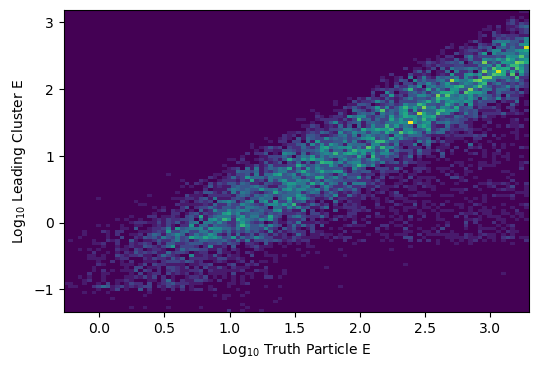

In [161]:
plt.figure(dpi=100)
plt.hist2d(df.log10_truth_particle_e, df.log10_cluster_e_0, bins=100);
plt.xlabel(r'Log$_{10}$ Truth Particle E');
plt.ylabel(r'Log$_{10}$ Leading Cluster E');

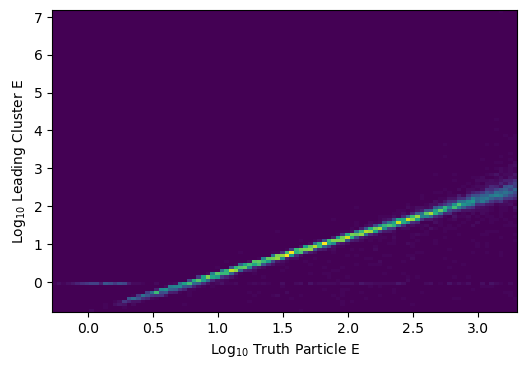

In [162]:
plt.figure(dpi=100)
plt.hist2d(df.log10_truth_particle_e, df.log10_track_pt, bins=100);
plt.xlabel(r'Log$_{10}$ Truth Particle E');
plt.ylabel(r'Log$_{10}$ Leading Cluster E');

In [ ]:
# plt.figure(dpi=100)
# plt.hist2d(df.log10_truth_particle_e, df.log10_cluster_e_0, bins=100);
# plt.xlabel(r'Log$_{10}$ Truth Particle E');
# plt.ylabel(r'Log$_{10}$ Leading Cluster E');

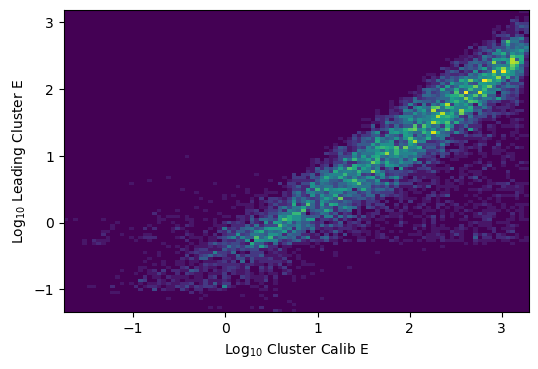

In [163]:
plt.figure(dpi=100)
plt.hist2d(df.log10_cluster_calib_e, df.log10_cluster_e_0, bins=100);
plt.xlabel(r'Log$_{10}$ Cluster Calib E');
plt.ylabel(r'Log$_{10}$ Leading Cluster E');

In [174]:
train_vars = [
    'log10_cluster_e_0',
    'log10_track_pt',
    'track_eta_0',
    'track_eta_1',
    'track_eta_2',
    'track_eta_3',
    'track_eta_4',
    'track_eta_5',
             ]
# target_var = ['log10_cluster_calib_e'] # cluster-only target
target_var = ['log10_truth_particle_e'] # cluster + track target

In [177]:
test = train(df, train_vars, target_var, batch_size=10, epochs=100)

Epoch 1/100
656/656 [==============================] - 1s 2ms/step - loss: 0.2829 - val_loss: 0.0398
Epoch 2/100
656/656 [==============================] - 1s 2ms/step - loss: 0.0441 - val_loss: 0.0325
Epoch 3/100
656/656 [==============================] - 1s 2ms/step - loss: 0.0340 - val_loss: 0.0494
Epoch 4/100
656/656 [==============================] - 1s 2ms/step - loss: 0.0333 - val_loss: 0.0303
Epoch 5/100
656/656 [==============================] - 1s 2ms/step - loss: 0.0323 - val_loss: 0.0272
Epoch 6/100
656/656 [==============================] - 1s 2ms/step - loss: 0.0288 - val_loss: 0.0323
Epoch 7/100
656/656 [==============================] - 1s 2ms/step - loss: 0.0279 - val_loss: 0.0293
Epoch 8/100
656/656 [==============================] - 1s 2ms/step - loss: 0.0292 - val_loss: 0.0280
Epoch 9/100
656/656 [==============================] - 1s 2ms/step - loss: 0.0267 - val_loss: 0.0305
Epoch 10/100
656/656 [==============================] - 1s 2ms/step - loss: 0.0279 - val_lo

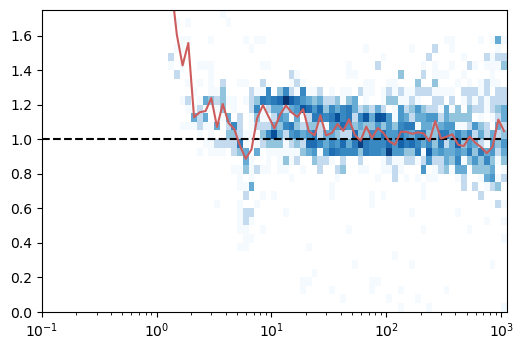

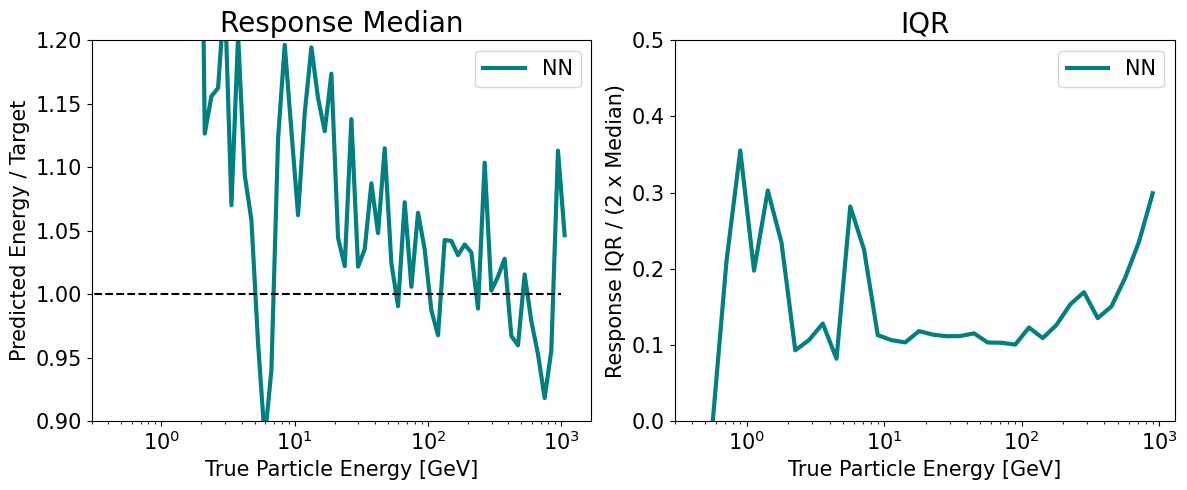

In [178]:
make_plots(test, plot_em=False, plot_track=False, 
#            save_label="dnn"
)